## 0\. Motivação

Supondo que tenha empreendedor no ramo imobiliário e ele quer decidir qual a melhor região para construir, será preciso todo um estudo comparativo para encontrar a resposta. 

Esse notebook tem como objetivo facilitar esse processo. Para isso, será feito uma comparação entre bases de dados distintas para se chegar nas áreas mais rentáveis para construção por m².

## 1\. Coleta de dados

In [1]:
import os
import re
import csv

import requests
from requests.exceptions import HTTPError
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

Primeiro será feita a coleta de dados pelo scraping, pois a base de dados está em HTML no site em questão. Os valores são referentes ao mês de Março de 2023.

In [89]:
import requests

# URL do site que você deseja verificar
url = 'https://www.agenteimovel.com.br/mercado-imobiliario/a-venda/sp/sao-paulo/'

# Fazendo a requisição GET ao site
response = requests.get(url)

# Verificando o código de status da resposta
status_code = response.status_code

# Verificando se ocorreu um erro
if status_code >= 400:
    print(f"Ocorreu um erro ao acessar a URL. Código de status: {status_code}")
else:
    print("A requisição foi bem-sucedida. O site está disponível.")

A requisição foi bem-sucedida. O site está disponível.


In [90]:
def crawl_website(url: str) -> str:

  try:
    resposta = requests.get(url)
    resposta.raise_for_status()
  except HTTPError as exc:
    print(exc)
  else:
    return resposta.text

URL = 'https://www.agenteimovel.com.br/mercado-imobiliario/a-venda/sp/sao-paulo/'

robots = crawl_website(url=URL)

if  re.findall('ranking', robots, re.IGNORECASE) == True or re.findall('project', robots, re.IGNORECASE) == False:
  print(True) 
else:
  print(False) 

False


In [91]:
URL = 'https://www.agenteimovel.com.br/mercado-imobiliario/a-venda/sp/sao-paulo/'
conteudo = crawl_website(url=URL)

pagina = BeautifulSoup(conteudo, 'html.parser')
tabela = pagina.find('table', {'class': 'bairro'}).text.split('\n\n\n')

In [92]:
dados = []
for linha in tabela:
    teste = linha.split('\n')
    dados.append(teste)

In [93]:
resultado = [[value.replace('R$', '').replace('%', '').replace('-','').replace('+','').replace('.','').strip() for value in linha if value] for linha in dados]
preco_m2_df = pd.DataFrame(resultado[1:], columns=resultado[0])
preco_m2_df = preco_m2_df[['Bairro','Preço/M²']].rename(columns={'Bairro':'district','Preço/M²':'price_per_m2'})

preco_m2_df['price_per_m2'] = preco_m2_df['price_per_m2'].astype('Int64')

preco_m2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   district      550 non-null    object
 1   price_per_m2  550 non-null    Int64 
dtypes: Int64(1), object(1)
memory usage: 9.3+ KB


Esse outro dataset foi retirado do Kaggle. Tal dataset tem como base os valores dos aluguéis disponiveis pelo Quinto Andar, um site de aluguéis de imóveis bem famoso. A data referência é a de Maio de 2023, apenas 2 meses a mais do que a outra base de dados anteriormente coletada.
 
Link: https://www.kaggle.com/datasets/renatosn/sao-paulo-housing-prices

In [94]:
# Leitura dos dados de locações em SP
sp_df = pd.read_csv('saopaulo_precos.csv')
sp_df

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654
...,...,...,...,...,...,...,...,...
11652,Avenida Adolfo Pinheiro,Santo Amaro,94,2,1,Apartamento,4100,5778
11653,Rua Professor Alexandre Correia,Jardim Vitória Régia,350,4,4,Apartamento,11250,17480
11654,Rua Abílio Borin,Jardim Caravelas,84,1,2,Apartamento,4500,5467
11655,Rua Forte William,Jardim Fonte do Morumbi,76,1,0,Apartamento,9000,10200


In [109]:
sp_df = pd.merge(left=sp_df,right=preco_m2_df)
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9048 entries, 0 to 9047
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   address       9048 non-null   object
 1   district      9048 non-null   object
 2   area          9048 non-null   int64 
 3   bedrooms      9048 non-null   int64 
 4   garage        9048 non-null   int64 
 5   type          9048 non-null   object
 6   rent          9048 non-null   int64 
 7   total         9048 non-null   int64 
 8   price_per_m2  9048 non-null   Int64 
dtypes: Int64(1), int64(5), object(3)
memory usage: 645.1+ KB


In [110]:
sp_df['valor_estimado_area'] = sp_df['area']*sp_df['price_per_m2']
sp_df

,address,district,area,bedrooms,garage,type,rent,total,price_per_m2,valor_estimado_area
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939,8184,171864
1,Avenida Celso Garcia,Belenzinho,44,2,1,Apartamento,1850,2321,8184,360096
2,Rua Herval,Belenzinho,40,1,0,Apartamento,1800,2069,8184,327360
3,Rua Herval,Belenzinho,30,1,0,Apartamento,1800,2069,8184,245520
4,Rua Serra da Mantiqueira,Belenzinho,100,3,0,Casa,3850,4113,8184,818400
...,...,...,...,...,...,...,...,...,...,...
9043,Rua João Teizen Sobrinho,Jardim Santa Helena,310,4,4,Casa,10000,11390,4852,1504120
9044,Rua Edmundo Amaral Valente,Parque Munhoz,56,2,2,Apartamento,1500,2188,5125,287000
9045,"Parque do Morumbi, São Paulo - Sp, 05706-290, ...",Parque do Morumbi,140,3,2,Apartamento,3000,4399,10357,1449980
9046,Avenida Dona Helena Pereira de Moraes,Parque do Morumbi,220,2,0,Apartamento,11250,16620,10357,2278540


Aqui eu retirei a lista dos bairros existentes em São Paulo, para delimitar apenas os endereços na cidade.

In [97]:
bairros = []

URL2 = 'https://www.estadosecapitaisdobrasil.com/lista-dos-bairros-de-sao-paulo/'
conteudo2 = crawl_website(url=URL2)

pagina2 = BeautifulSoup(conteudo2, 'html.parser')
tabela2 = pagina2.find('div', {'class': 'content col-8'}).find_all('ul')

for linha in tabela2:
    if linha is None:
        continue
    
    linha = str(linha)
    
    linha = linha.replace('\n', '').replace('</ul>', '').replace('</li>','').replace('\u200e','')
    
    nomes = linha.split('<li>')[1:]
    
    nomes = [nome.strip().rstrip('') for nome in nomes]
    
    bairros.extend(nomes)

print(bairros)

['Água Rasa', 'Alto de Pinheiros', 'Anhanguera', 'Aricanduva', 'Artur Alvim', 'Barra Funda', 'Bela Vista', 'Belém', 'Bom Retiro', 'Brasilândia', 'Butantã', 'Cachoeirinha', 'Cambuci', 'Campo Belo', 'Campo Grande', 'Campo Limpo', 'Cangaíba', 'Capão Redondo', 'Carrão', 'Casa Verde', 'Cidade Ademar', 'Cidade Dutra', 'Cidade Líder', 'Cidade Líder', 'Cidade Tiradentes', 'Consolação', 'Cursino', 'Ermelino Matarazzo', 'Freguesia do Ó', 'Grajaú', 'Guaianases', 'Iguatemi', 'Ipiranga', 'Itaim Bibi', 'Itaim Paulista', 'Itaquera', 'Jabaquara', 'Jaçanã', 'Jaguara', 'Jaguaré', 'Jaraguá', 'Jardim Ângela', 'Jardim Helena', 'Jardim Paulista', 'Jardim São Luís', 'Lapa', 'Liberdade', 'Limão', 'Mandaqui', 'Marsilac', 'Moema', 'Mooca', 'Morumbi', 'Parelheiros', 'Pari', 'Parque do Carmo', 'Penha', 'Perdizes', 'Pinheiros', 'Ponte Rasa', 'Raposo Tavares', 'República', 'Rio Pequeno', 'Sacomã', 'Santa Cecília', 'Santana', 'Santo Amaro', 'São Domingos', 'São Lucas', 'São Mateus', 'São Miguel Paulista', 'São Rafae

In [111]:
df = sp_df[sp_df['district'].isin(bairros)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3542 entries, 37 to 9018
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   address              3542 non-null   object
 1   district             3542 non-null   object
 2   area                 3542 non-null   int64 
 3   bedrooms             3542 non-null   int64 
 4   garage               3542 non-null   int64 
 5   type                 3542 non-null   object
 6   rent                 3542 non-null   int64 
 7   total                3542 non-null   int64 
 8   price_per_m2         3542 non-null   Int64 
 9   valor_estimado_area  3542 non-null   Int64 
dtypes: Int64(2), int64(5), object(3)
memory usage: 311.3+ KB


## 2\. Exploração dos dados

O intuito aqui é gerar os dados de geolocalização para posteriormente gerar o mapa dos imóveis da cidade de São Paulo com esses valores.

In [99]:
# Geocodificação dos endereços
geolocator = Nominatim(user_agent="caiombr", timeout=5)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [100]:
df['location'] = df['address'] + ', ' + df['district'] + ', São Paulo, SP' # Concatena o endereço com a cidade e estado

df['coordinates'] = df['location'].apply(geocode).apply(lambda x: (x.latitude, x.longitude) if x else None)


C:\Users\caiom\AppData\Local\Temp\ipykernel_13512\3737962230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location'] = df['address'] + ', ' + df['district'] + ', São Paulo, SP' # Concatena o endereço com a cidade e estado
C:\Users\caiom\AppData\Local\Temp\ipykernel_13512\3737962230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coordinates'] = df['location'].apply(geocode).apply(lambda x: (x.latitude, x.longitude) if x else None)


In [107]:
df.to_csv('dataframe_backup.csv')

Eu gerei o arquivo em CSV para não ter que fazer a leitura do arquivo toda vez que eu for trabalhar no projeto

In [62]:
data = pd.read_csv('dataframe.csv')
data = data.drop(['Unnamed: 0','address','location'], axis=1)
# data = data.drop(['Unnamed: 0','address','location','bedrooms','garage'], axis=1)
data.head()

,district,area,bedrooms,garage,type,rent,total,price_per_m2,valor_estimado_area,coordinates
0,Pinheiros,18,1,0,Apartamento,4000,4661,15337,276066,"(-23.5507897, -46.6787724)"
1,Pinheiros,19,1,0,Studio e kitnet,3400,3905,15337,291403,"(-23.5507897, -46.6787724)"
2,Pinheiros,34,1,1,Studio e kitnet,3231,4083,15337,521458,"(-23.566351, -46.6856195)"
3,Pinheiros,33,1,0,Studio e kitnet,3417,4018,15337,506121,"(-23.5501258, -46.6822123)"
4,Pinheiros,34,1,1,Apartamento,4850,5677,15337,521458,"(-23.5703061, -46.7001637)"


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3542 entries, 0 to 3541
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   district             3542 non-null   object
 1   area                 3542 non-null   int64 
 2   bedrooms             3542 non-null   int64 
 3   garage               3542 non-null   int64 
 4   type                 3542 non-null   object
 5   rent                 3542 non-null   int64 
 6   total                3542 non-null   int64 
 7   price_per_m2         3542 non-null   int64 
 8   valor_estimado_area  3542 non-null   int64 
 9   coordinates          3160 non-null   object
dtypes: int64(7), object(3)
memory usage: 276.8+ KB


In [64]:
# Limpeza dos dados nulos
data = data.dropna()

In [65]:
data.head()

,district,area,bedrooms,garage,type,rent,total,price_per_m2,valor_estimado_area,coordinates
0,Pinheiros,18,1,0,Apartamento,4000,4661,15337,276066,"(-23.5507897, -46.6787724)"
1,Pinheiros,19,1,0,Studio e kitnet,3400,3905,15337,291403,"(-23.5507897, -46.6787724)"
2,Pinheiros,34,1,1,Studio e kitnet,3231,4083,15337,521458,"(-23.566351, -46.6856195)"
3,Pinheiros,33,1,0,Studio e kitnet,3417,4018,15337,506121,"(-23.5501258, -46.6822123)"
4,Pinheiros,34,1,1,Apartamento,4850,5677,15337,521458,"(-23.5703061, -46.7001637)"


Preciso transformar as coordenadas em latitude e longitude, para posteriormente facilitar o processamento da plotagem.

In [67]:
data[['latitude', 'longitude']] = data['coordinates'].str.strip('()').str.split(', ', expand=True)
data['latitude'] = data['latitude'].astype(float)
data['longitude'] = data['longitude'].astype(float)

data_filtro = data.loc[(data['longitude'] >= -47) & (data['longitude'] <= -46)]
data_filtro = data_filtro.loc[(data['latitude'] >= -24) & (data['latitude'] <= -23)]
data = data_filtro.drop('coordinates',axis=1)

In [71]:
data.head()

,district,area,bedrooms,garage,type,rent,total,price_per_m2,valor_estimado_area,latitude,longitude
0,Pinheiros,18,1,0,Apartamento,4000,4661,15337,276066,-23.550790,-46.678772
1,Pinheiros,19,1,0,Studio e kitnet,3400,3905,15337,291403,-23.550790,-46.678772
2,Pinheiros,34,1,1,Studio e kitnet,3231,4083,15337,521458,-23.566351,-46.685620
3,Pinheiros,33,1,0,Studio e kitnet,3417,4018,15337,506121,-23.550126,-46.682212
4,Pinheiros,34,1,1,Apartamento,4850,5677,15337,521458,-23.570306,-46.700164


In [73]:
teste = data[['district','type','valor_estimado_area']]
teste['contagem'] = 1


C:\Users\caiom\AppData\Local\Temp\ipykernel_9552\428901738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['contagem'] = 1


In [59]:
teste.sort_values('valor_estimado_area',ascending=0).head()

,district,type,valor_estimado_area,contagem
1967,Campo Belo,Casa,6845700,1
2910,Jardim Paulista,Apartamento,6020377,1
1996,Campo Belo,Casa,6005000,1
1998,Campo Belo,Casa,5980980,1
1997,Campo Belo,Casa,5788820,1


In [60]:
teste_type = teste[['type','contagem']].groupby('type').count().reset_index().sort_values('contagem',ascending=0)
teste_type

,type,contagem
0,Apartamento,2152
3,Studio e kitnet,535
1,Casa,415
2,Casa em condomínio,31


In [61]:
teste_district = teste[['district','contagem']].groupby('district').count().reset_index().sort_values('contagem',ascending=0)
teste_district.head(5)

,district,contagem
2,Bela Vista,272
20,Jardim Paulista,219
50,Vila Mariana,210
31,Pinheiros,155
36,Santana,151


## 3\. Modelagem dos dados

Agora será feito a modelagem dos dados para o processo de aprendizagemd e maquina.

In [72]:
data_1 = data.drop(['price_per_m2','rent','latitude','longitude'], axis=1)
data_1.head()

,district,area,bedrooms,garage,type,total,valor_estimado_area
0,Pinheiros,18,1,0,Apartamento,4661,276066
1,Pinheiros,19,1,0,Studio e kitnet,3905,291403
2,Pinheiros,34,1,1,Studio e kitnet,4083,521458
3,Pinheiros,33,1,0,Studio e kitnet,4018,506121
4,Pinheiros,34,1,1,Apartamento,5677,521458


## 4\. Visualização

In [20]:
mapa = geopandas.read_file("./DISTRITO_MUNICIPAL_SP_SMDU/DISTRITO_MUNICIPAL_SP_SMDUPolygon.shp")

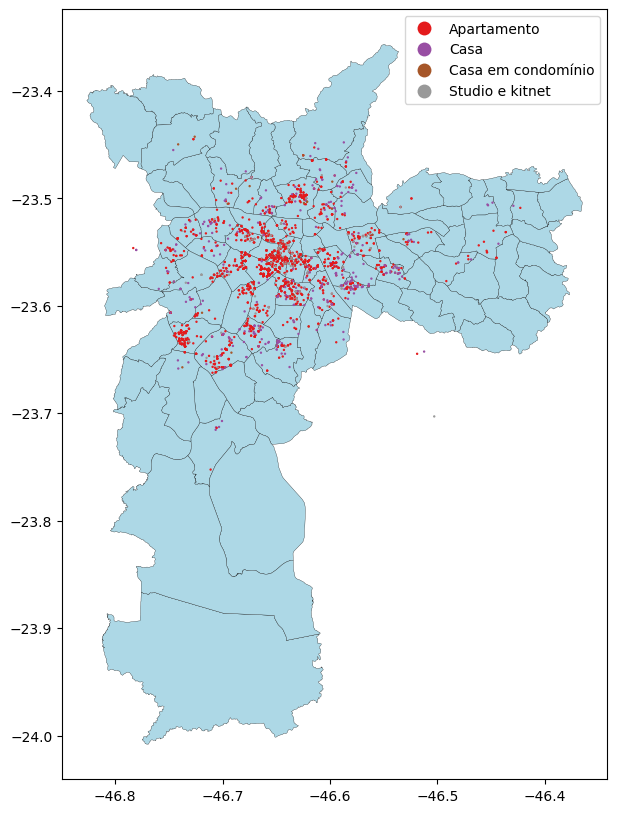

In [21]:
geo_df = geopandas.GeoDataFrame(data, geometry=geopandas.points_from_xy(data['longitude'], data['latitude']))

fig, ax = plt.subplots(figsize=(10, 10))

mapa.plot(ax=ax,alpha=1,color='lightblue',linewidth=0.2, edgecolor='black')

geo_df.plot(ax=ax, markersize=0.5,categorical=True, column='type', legend=True, legend_kwds={'bbox_to_anchor': (1, 1)}, cmap='Set1')

plt.show()